## Определение возраста по фотографии

### 1. Анализ данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Прочитаем файл с метками и сохраним его в переменной *labels*. Посмотрим датафрейм и общую информацию о нём.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()
labels.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Датафрейм содержит 7591 строк и 2 столбца с информацией об имени файла и возрасте человека, изображённого на соответствующей фотографии. Посмотрим 12 фотографий из датасета.

Found 7591 validated image filenames.


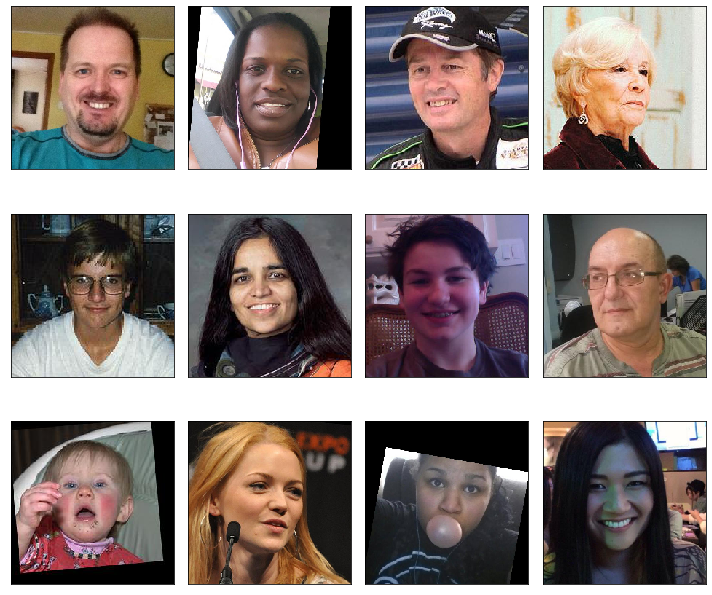

In [3]:
def print_images(labels):
    train_datagen = ImageDataGenerator(rescale=1/255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory='/datasets/faces/final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       seed=12345)

    features, target = next(train_gen_flow)
    fig = plt.figure(figsize=(10,10))
    for i in range(12):
        fig.add_subplot(3, 4, i+1)
        plt.imshow(features[i])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    
print_images(labels)

Фотографии сделаны с разных ракурсов, на них изображены люди разного возраста, пола и расы.

Построим график распределения возраста в выборке.

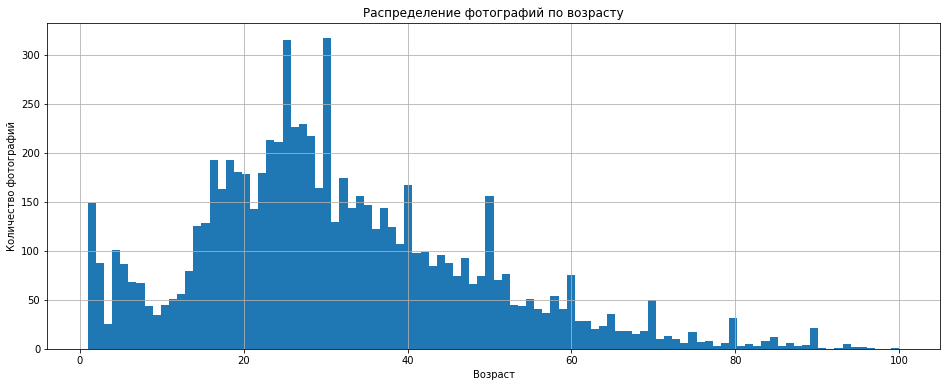

In [4]:
fig, ax = plt.subplots(figsize=(16, 6))
labels.hist(bins=100, ax=ax)
ax.set_title('Распределение фотографий по возрасту')
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество фотографий');

Наиболее массово в датасете представлены фотографии молодых людей, а также людей среднего возраста. Помимо этого на гистограмме выделяется младшая возрастная группа, в частности дети, достигшие 1 года. Такой выброс мог быть вызван как объединением нескольких выборок в одну, так и ошибками в разметке. Чтобы исключить это, проверим соответствуют ли люди на данных фотографиях заявленному возрасту.

Found 149 validated image filenames.


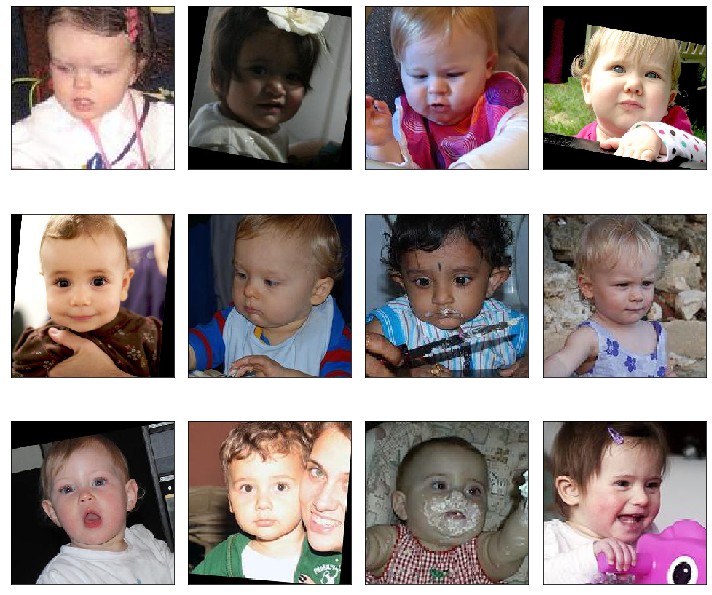

In [5]:
print_images(labels[labels['real_age']==1])

Все 12 случайно выбранных фотографий принадлежат детям, следовательно даже если ошибки в разметке и присутствуют, то не носят массовый характер. 

Несмотря на то, что дети младшего возраста не могут быть самостоятельными покупателями, определение их возраста будет полезно для составления рекомендаций, поэтому при обучении и тестировании модели следует использовать весь датасет.

### 2. Обучение нейронной сети

Построим свёрточную нейронную сеть на основе архитектуры *ResNet50* с функцией потерь *MSE* и оптимизационным алгоритмом *Adam*.

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25,
                                       horizontal_flip=True, rotation_range=10,
                                       width_shift_range=0.2, height_shift_range=0.2)
    train_data = train_datagen.flow_from_dataframe(dataframe=labels,
                                                   directory=path + 'final_files/',
                                                   x_col='file_name',
                                                   y_col='real_age',
                                                   target_size=(224, 224),
                                                   batch_size=32,
                                                   class_mode='raw',
                                                   subset='training',
                                                   seed=12345)
    return train_data

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='raw',
                                                 subset='validation',
                                                 seed=12345)
    return test_data


def create_model(input_shape):
    model = Sequential() 
    optimizer=Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 171s - loss: 230.0435 - mae: 10.9685 - val_loss: 973.0247 - val_mae: 26.4503
Epoch 2/6
178/178 - 97s - loss: 91.1170 - mae: 7.1496 - val_loss: 846.6801 - val_mae: 24.1838
Epoch 3/6
178/178 - 97s - loss: 74.4918 - mae: 6.5598 - val_loss: 347.0648 - val_mae: 13.8263
Epoch 4/6
178/178 - 97s - loss: 59.5319 - mae: 5.8871 - val_loss: 129.8538 - val_mae: 8.6147
Epoch 5/6
178/178 - 97s - loss: 50.5597 - mae: 5.4554 - val_loss: 110.3547 - val_mae: 7.8562
Epoch 6/6
178/178 - 97s - loss: 41.5057 - mae: 4.9646 - val_loss: 74.9904 - val_mae: 6.3843

60/60 - 10s - loss: 74.9904 - mae: 6.3843
Test MAE: 6.3843
```

### 3. Анализ обученной нейросети

В ходе выполнения задачи использовались модели с различными гиперпараметрами. Наилучшим образом себя показала свёрточная нейронная сеть на основе архитектуры *ResNet50* с *learning_rate* оптимизатора, равным 0.0001, и применением на обучающей выборке следующих аугментаций: отражений, поворотов и сдвигов. В процессе обучения значение функции потерь стабильно снижалось. Модель обучена на 6 эпохах, так как при дальнейшем их увеличении начинало сказываться переобучение, в результате чего средняя ошибка определения возраста увеличивалась. Итоговое значение *MAE* на тестовой выборке составило 6.3843.